In [1]:
import pandas as pd
import numpy as np

## Text Mining and Preprocessing

In [4]:
df = pd.read_csv('data/enron_emails_clean.csv')
df.head()

,Message-ID,From,To,Date,content,clean_content
0,<8345058.1075840404046.JavaMail.evans@thyme>,('advdfeedback@investools.com'),('advdfeedback@investools.com'),2002-01-29 23:20:55,INVESTools Advisory\nA Free Digest of Trusted ...,investools advisory free digest trusted invest...
1,<1512159.1075863666797.JavaMail.evans@thyme>,('richard.sanders@enron.com'),('richard.sanders@enron.com'),2000-09-20 19:07:00,----- Forwarded by Richard B Sanders/HOU/ECT o...,forwarded richard b sanders hou ect pm justin ...
2,<26118676.1075862176383.JavaMail.evans@thyme>,('m..love@enron.com'),('m..love@enron.com'),2001-10-30 16:15:17,hey you are not wearing your target purple shi...,hey wearing target purple shirt today mine wan...
3,<10369289.1075860831062.JavaMail.evans@thyme>,('leslie.milosevich@kp.org'),('leslie.milosevich@kp.org'),2002-01-30 17:54:18,Leslie Milosevich\n1042 Santa Clara Avenue\nAl...,leslie milosevich santa clara avenue alameda c...
4,<26728895.1075860815046.JavaMail.evans@thyme>,('rtwait@graphicaljazz.com'),('rtwait@graphicaljazz.com'),2002-01-30 19:36:01,"Rini Twait\n1010 E 5th Ave\nLongmont, CO 80501...",rini twait e th ave longmont co rtwait graphic...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2090 entries, 0 to 2089
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Message-ID     2090 non-null   object
 1   From           2090 non-null   object
 2   To             2090 non-null   object
 3   Date           2090 non-null   object
 4   content        2090 non-null   object
 5   clean_content  2086 non-null   object
dtypes: object(6)
memory usage: 98.1+ KB


## Cleaning the text

Must dos when working with textual data:
1. Tokenization
2. Remove all stopwords
3. Lemmatize your words
4. Stem your words


In [6]:
df["content"].head()

0    INVESTools Advisory\nA Free Digest of Trusted ...
1    ----- Forwarded by Richard B Sanders/HOU/ECT o...
2    hey you are not wearing your target purple shi...
3    Leslie Milosevich\n1042 Santa Clara Avenue\nAl...
4    Rini Twait\n1010 E 5th Ave\nLongmont, CO 80501...
Name: content, dtype: object

In [7]:
df['clean_content'].head()

0    investools advisory free digest trusted invest...
1    forwarded richard b sanders hou ect pm justin ...
2    hey wearing target purple shirt today mine wan...
3    leslie milosevich santa clara avenue alameda c...
4    rini twait e th ave longmont co rtwait graphic...
Name: clean_content, dtype: object

### Create the embeddings

In [8]:
import google.generativeai as genai

genai.configure(api_key="GOOGLE_API_KEY")

In [9]:
df["clean_content"].head(20)

0     investools advisory free digest trusted invest...
1     forwarded richard b sanders hou ect pm justin ...
2     hey wearing target purple shirt today mine wan...
3     leslie milosevich santa clara avenue alameda c...
4     rini twait e th ave longmont co rtwait graphic...
5     laurent meillier jackson stq oakland ca guelag...
6     dear mr whalley hope take time read content me...
7     jan nissl e state boise id jnissl healthwise o...
8     much nice machine original message baumbach da...
9     leigh clemons seyburn drive baton rouge la rob...
10    judith baldwin whitney avenue new ct jbaldwin ...
11    please respond motley fool motley fool investi...
12    sizable staff lawyers merger limbo houston ap ...
13    today announced plans merge dynegy major playe...
14    today announced plans merge dynegy major playe...
15    jana rubin white wing court norcross ga jhr vi...
16    draft position report talked previously delaye...
17    ask ir original message clark mary sent fr

Average word count: 221.31
Median word count: 95.00
Max word count: 23857.0
Min word count: 1.0

Percentiles:
count     2086.000000
mean       221.313519
std        886.629883
min          1.000000
25%         35.000000
50%         95.000000
75%        181.000000
max      23857.000000
Name: clean_content, dtype: float64


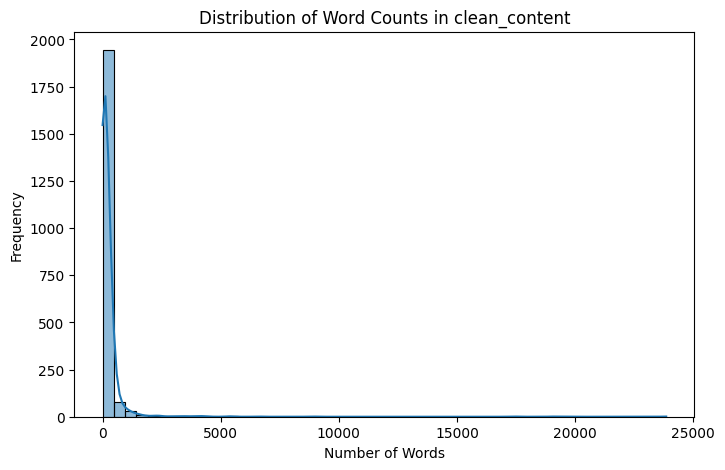

In [10]:
# Create histogram using matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# Count words in each row
word_counts = df["clean_content"].str.split().str.len()

plt.figure(figsize=(8, 5))
sns.histplot(word_counts, bins=50, edgecolor='black', kde=True)
plt.title('Distribution of Word Counts in clean_content')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

# Add some statistics
print(f"Average word count: {word_counts.mean():.2f}")
print(f"Median word count: {word_counts.median():.2f}")
print(f"Max word count: {word_counts.max()}")
print(f"Min word count: {word_counts.min()}")
print("\nPercentiles:")
print(word_counts.describe())

In [11]:
from tqdm import tqdm  # Import tqdm for displaying a progress bar in loops
from google.api_core import retry  # Import retry functionality for handling retries in embedding operations

tqdm.pandas()  # Enable the progress bar for Pandas operations

def make_embed_text_fn(model):  # Define a function to create embeddings using a specified model

    @retry.Retry(timeout=300)  # Add a retry decorator to handle timeouts during the embedding process
    def embed_fn(text: str) -> list[float]:  
        # Inner function to process a single text and return its embedding as a list of floats
        
        truncated_text = ' '.join(str(text).split()[:800])  
        # Truncate the input text to the first 800 words to ensure it fits the model's input limits
        # Note: The truncation to 800 words in the embedding function is done for API Limitations.
        
        embedding = genai.embed_content(
            model=model,  # Use the specified model for generating embeddings
            content=truncated_text,  # Pass the truncated text to the embedding function
            task_type="clustering"  # Specify the task type as clustering for embedding generation
        )
        return np.array(embedding)  
        # Convert the resulting embedding to a NumPy array and return it
    
    return embed_fn  # Return the embedding function

def create_embeddings(df):  # Define a function to apply embedding generation to a DataFrame
    model = "models/embedding-001"
    # Specify the model to be used for generating embeddings
    
    df["Embeddings"] = df["clean_content"].progress_apply(make_embed_text_fn(model))  
    # Apply the embedding function to the 'clean_content' column and store the results in a new column 'Embeddings'
    
    return df  # Return the updated DataFrame with the new 'Embeddings' column

df = create_embeddings(df)  # Generate embeddings for the DataFrame using the create_embeddings function
df.head()  # Display the first few rows of the updated DataFrame

  0%|          | 0/2090 [00:00<?, ?it/s]

100%|██████████| 2090/2090 [10:57<00:00,  3.18it/s]


,Message-ID,From,To,Date,content,clean_content,Embeddings
0,<8345058.1075840404046.JavaMail.evans@thyme>,('advdfeedback@investools.com'),('advdfeedback@investools.com'),2002-01-29 23:20:55,INVESTools Advisory\nA Free Digest of Trusted ...,investools advisory free digest trusted invest...,"{'embedding': [0.0060157324, -0.0055038417, -0..."
1,<1512159.1075863666797.JavaMail.evans@thyme>,('richard.sanders@enron.com'),('richard.sanders@enron.com'),2000-09-20 19:07:00,----- Forwarded by Richard B Sanders/HOU/ECT o...,forwarded richard b sanders hou ect pm justin ...,"{'embedding': [0.0122758085, -0.038377106, -0...."
2,<26118676.1075862176383.JavaMail.evans@thyme>,('m..love@enron.com'),('m..love@enron.com'),2001-10-30 16:15:17,hey you are not wearing your target purple shi...,hey wearing target purple shirt today mine wan...,"{'embedding': [-0.010328788, -0.006901007, -0...."
3,<10369289.1075860831062.JavaMail.evans@thyme>,('leslie.milosevich@kp.org'),('leslie.milosevich@kp.org'),2002-01-30 17:54:18,Leslie Milosevich\n1042 Santa Clara Avenue\nAl...,leslie milosevich santa clara avenue alameda c...,"{'embedding': [0.010876484, 0.02684665, -0.031..."
4,<26728895.1075860815046.JavaMail.evans@thyme>,('rtwait@graphicaljazz.com'),('rtwait@graphicaljazz.com'),2002-01-30 19:36:01,"Rini Twait\n1010 E 5th Ave\nLongmont, CO 80501...",rini twait e th ave longmont co rtwait graphic...,"{'embedding': [0.011247741, 0.01880242, -0.041..."


In [12]:
pd.set_option('display.max_colwidth', 300)  # Show full content of each column

df[["clean_content", "Embeddings"]].head(10)

,clean_content,Embeddings
0,investools advisory free digest trusted investment advice unsubscribe free newsletter please see issue fried sells stocks gains months km rowe january index confirms bull market aloy small cap advisor earns lbix compounding returns pine trees pcl undervalued high yield bank puts customers first ...,"{'embedding': [0.0060157324, -0.0055038417, -0.02959923, -0.02488608, 0.08546625, 0.014614865, -0.0051528565, -0.01266613, 0.029216005, 0.015661707, 0.014663395, 0.015103532, 0.031179938, -0.0136181945, -0.005468941, -0.042712867, 0.03412558, -0.030630529, 0.013160095, -0.048023712, 0.011670577,..."
1,forwarded richard b sanders hou ect pm justin boyd richard b sanders hou ect ect cc subject mg plc rudolph wolfe richard please see justin forwarded justin boyd lon ect justin boyd philippa broom glegal com enron cc subject mg plc rudolph wolfe many thanks enron capital trade resources corp phil...,"{'embedding': [0.0122758085, -0.038377106, -0.042272486, -0.003459732, 0.06838997, -0.002056447, -0.023792487, 0.022386786, 0.04338023, 0.035892528, 0.016295394, 0.05417085, -0.011609129, -0.016399922, -0.025810573, -0.078710124, 0.04318627, 0.0009649096, 0.011309946, -0.04407102, -0.0091386335,..."
2,hey wearing target purple shirt today mine want look silly original message baumbach david sent tuesday october love phillip subject league dues team looks good paper come play rc going call original message love phillip sent tuesday october baumbach david subject league dues much nice machine o...,"{'embedding': [-0.010328788, -0.006901007, -0.003756879, -0.025810413, 0.025278596, -0.020165585, 0.009241373, -0.025568658, 0.027218848, -0.016725902, 0.023973001, 0.040223446, -0.0096165845, -0.023383249, -0.011013853, -0.024224758, 0.007185911, -0.0076394165, 0.008723333, -0.05265163, -0.0397..."
3,leslie milosevich santa clara avenue alameda ca leslie milosevich kp org mr ken lay writing urge donate millions dollars made selling enron stock company declared bankruptcy funds enron employee transition fund reach benefit company employees lost retirement savings provide relief low income con...,"{'embedding': [0.010876484, 0.02684665, -0.03151946, -0.028301438, 0.094766214, 0.012343317, 0.023879603, -0.0098642735, 0.005146673, 0.017798614, 0.007878798, 0.03404809, -0.015836863, -0.033018824, -0.014300105, -0.049545616, 0.04978233, 0.021885699, 0.045113645, -0.037970856, 0.035291858, -0...."
4,rini twait e th ave longmont co rtwait graphicaljazz com mr ken lay writing urge donate millions dollars made selling enron stock company declared bankruptcy funds enron employee transition fund reach benefit company employees lost retirement savings provide relief low income consumers californi...,"{'embedding': [0.011247741, 0.01880242, -0.04194779, -0.034327477, 0.09013479, -7.177654e-05, 0.020459557, 0.0033568111, 0.007976829, 0.058798213, 0.0077352636, 0.00922842, -0.038280487, -0.030610515, -0.003179414, -0.048086252, 0.058894236, 0.025736948, 0.03862518, -0.042607255, 0.029588412, 0...."
5,laurent meillier jackson stq oakland ca guelaguetza club lemonde fr mr ken lay writing urge donate millions dollars made selling enron stock company declared bankruptcy funds enron employee transition fund reach benefit company employees lost retirement savings provide relief low income consumer...,"{'embedding': [-5.9929036e-05, -0.0018676167, -0.037873916, -0.023479242, 0.08377961, 0.006246764, 0.013249246, 0.020705855, 0.007492257, 0.054880872, -0.008299551, 0.03428039, -0.050463658, -0.010768998, 0.009665221, -0.042815447, 0.05446995, 0.02849604, 0.017907618, -0.013256448, 0.011806196, ..."
6,dear mr whalley hope take time read content message sent dynegy afternoon much time elapses understand military academy graduate ex armored corps officer share similar background though academy rma sandhurst england ex artillery common trust knowledge men need led many men women employed enron p...,"{'embedding': [-0.0034649451, -0.0013897226, -0

In [13]:
len(pd.DataFrame(df["Embeddings"][0]))

768

## Dimensionality Reduction
###  t-Distributed Stochastic Neighbor Embedding (t-SNE)

The goal of dimensionality reduction is to reduce the number of features in a dataset while preserving the most important information. Using a technique called t-SNE, we can reduce the dimensionality of the embeddings to 2 dimensions. This will allow us to plot the embeddings in a 2D space. t-SNE is a non-linear dimensionality reduction technique that is particularly useful for visualizing high-dimensional datasets, such as the embeddings of emails. This approach is based on the idea that the data points in a high-dimensional space can be mapped to a lower-dimensional space while preserving the local structure of the data, preserving clusters and patterns in the data.


In [14]:
# Convert the embeddings to a numpy array

# Convert the embeddings to a numpy array
embeddings_array = np.array([emb['embedding'] for emb in df["Embeddings"]], dtype=np.float32)
embeddings_array.shape

(2090, 768)

In [16]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Initialize the t-SNE model    

tsne = TSNE(n_components=2, # This is the number of components to reduce the dimensionality to
            perplexity=30, # This is the perplexity of the t-SNE algorithm, a parameter that controls the effective number of neighbors
            learning_rate=200, # This is the learning rate of the t-SNE algorithm, a parameter that controls the step size during optimization
            max_iter=1000, # This is the number of iterations to run the t-SNE algorithm, a parameter that controls the number of iterations
            random_state=42 # This is the random state of the t-SNE algorithm, a parameter that controls the random initialization of the t-SNE algorithm
            )

tsne_embeddings = tsne.fit_transform(embeddings_array)

scaler = StandardScaler()
tsne_embeddings_scaled = scaler.fit_transform(tsne_embeddings)

pd.DataFrame(tsne_embeddings_scaled).head(20)

,0,1
0,-1.472167,-0.947866
1,-0.041172,0.183099
2,-1.160940,-0.019546
3,0.511041,-2.079606
4,0.132517,-2.052758
5,0.462711,-2.013751
6,-0.028483,-1.365900
7,0.293967,-2.287995
8,-1.159890,-0.020177
9,0.264891,-2.361988


In [17]:
df_tsne = df.copy()
pd.set_option('display.max_colwidth', 100)  # Show full content of each column

df_tsne[["TSNE_1", "TSNE_2"]] = pd.DataFrame(tsne_embeddings_scaled, columns=["TSNE_1", "TSNE_2"])
df_tsne

,Message-ID,From,To,Date,content,clean_content,Embeddings,TSNE_1,TSNE_2
0,<8345058.1075840404046.JavaMail.evans@thyme>,('advdfeedback@investools.com'),('advdfeedback@investools.com'),2002-01-29 23:20:55,INVESTools Advisory\nA Free Digest of Trusted Investment Advice\n\nTo unsubscribe from this free...,investools advisory free digest trusted investment advice unsubscribe free newsletter please see...,"{'embedding': [0.0060157324, -0.0055038417, -0.02959923, -0.02488608, 0.08546625, 0.014614865, -...",-1.472167,-0.947866
1,<1512159.1075863666797.JavaMail.evans@thyme>,('richard.sanders@enron.com'),('richard.sanders@enron.com'),2000-09-20 19:07:00,----- Forwarded by Richard B Sanders/HOU/ECT on 09/20/2000 07:07 PM -----\n\n\tJustin Boyd\n\t09...,forwarded richard b sanders hou ect pm justin boyd richard b sanders hou ect ect cc subject mg p...,"{'embedding': [0.0122758085, -0.038377106, -0.042272486, -0.003459732, 0.06838997, -0.002056447,...",-0.041172,0.183099
2,<26118676.1075862176383.JavaMail.evans@thyme>,('m..love@enron.com'),('m..love@enron.com'),2001-10-30 16:15:17,hey you are not wearing your target purple shirt today are you? I have mine on and I don't want...,hey wearing target purple shirt today mine want look silly original message baumbach david sent ...,"{'embedding': [-0.010328788, -0.006901007, -0.003756879, -0.025810413, 0.025278596, -0.020165585...",-1.160940,-0.019546
3,<10369289.1075860831062.JavaMail.evans@thyme>,('leslie.milosevich@kp.org'),('leslie.milosevich@kp.org'),2002-01-30 17:54:18,"Leslie Milosevich\n1042 Santa Clara Avenue\nAlameda, CA 94501\nleslie.milosevich@kp.org\n\nTo Mr...",leslie milosevich santa clara avenue alameda ca leslie milosevich kp org mr ken lay writing urge...,"{'embedding': [0.010876484, 0.02684665, -0.03151946, -0.028301438, 0.094766214, 0.012343317, 0.0...",0.511041,-2.079606
4,<26728895.1075860815046.JavaMail.evans@thyme>,('rtwait@graphicaljazz.com'),('rtwait@graphicaljazz.com'),2002-01-30 19:36:01,"Rini Twait\n1010 E 5th Ave\nLongmont, CO 80501\nrtwait@graphicaljazz.com\n\nTo Mr. Ken Lay,\n\nI...",rini twait e th ave longmont co rtwait graphicaljazz com mr ken lay writing urge donate millions...,"{'embedding': [0.011247741, 0.01880242, -0.04194779, -0.034327477, 0.09013479, -7.177654e-05, 0....",0.132517,-2.052758
...,...,...,...,...,...,...,...,...,...
2085,<19039088.1075851547721.JavaMail.evans@thyme>,('andy.zipper@enron.com'),('andy.zipper@enron.com'),2001-10-22 14:00:17,"i bot 1,000/d at 3.175 apr/oct02. put it against the digital in gas-x.\n\nthanks",bot apr oct put digital gas x thanks,"{'embedding': [0.041187704, -0.058975942, -0.053098306, -0.018809, -0.0018031129, -0.009272053, ...",1.894027,0.572757
2086,<6813352.1075842016977.JavaMail.evans@thyme>,('andy.zipper@enron.com'),('andy.zipper@enron.com'),2002-01-25 17:39:38,I'm okay. How are you ?,okay,"{'embedding': [0.025752537, -0.03856724, -0.06637583, -0.029054012, 0.040250946, -0.022814268, -...",-0.791879,1.613964
2087,<4833106.1075842022184.JavaMail.evans@thyme>,('tradersummary@syncrasy.com'),('tradersummary@syncrasy.com'),2002-02-01 16:15:17,"\n[IMAGE]=09\n\n\n[IMAGE] [IMAGE][IMAGE][IMAGE][IMAGE][IMAGE][IMAGE][IMAGE] Syncrasy, =\n...",image image image image image image image image image syncrasy llc fax texas avenue suite h oust...,"{'embedding': [0.004549993, -0.024302147, -0.019237202, -0.018468311, 0.03208425, 0.008354705, 0...",-0.189357,-1.226607
2088,<3550151.1075842023814.JavaMail.evans@thyme>,('lmrig@qwest.net'),('lmrig@qwest.net'),2002-01-29 02:01:00,"\n\nTransmission Expansion and Systems in Transition Conference\nFeb. 5-8, 2002, Miami, Florid...",transmission expansion systems transition conference feb miami florida overview conference exami...,"{'embedding': [0.005609878, 0.008236651, -0.03638275, 0.04289331, 0.046994116, -0.00052171166, 0...",0.465391,-0.878047


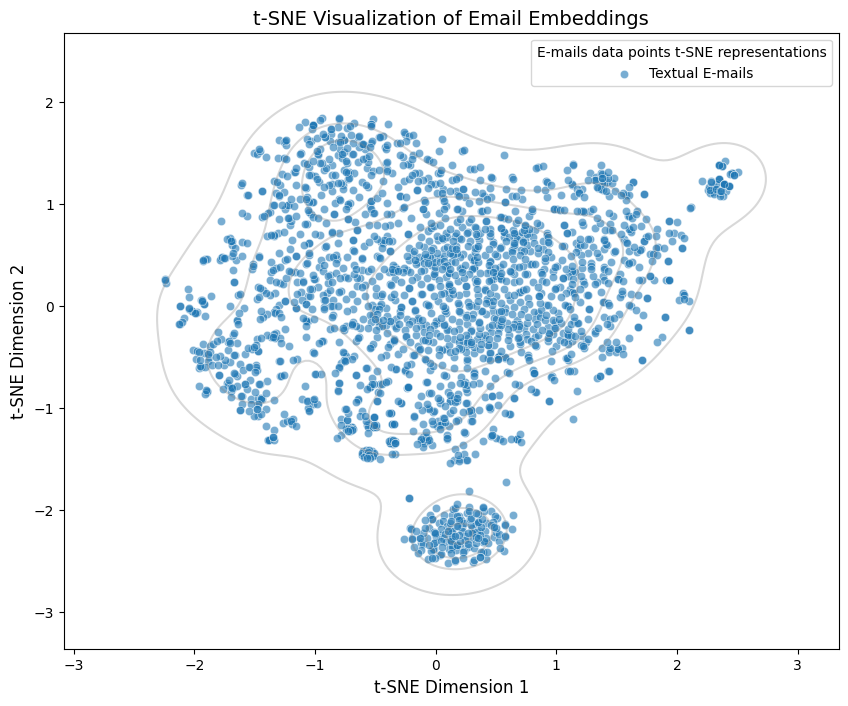


Distribution of points:


,TSNE_1,TSNE_2
count,2.090000e+03,2.090000e+03
mean,-1.095128e-08,-2.920342e-08
std,1.000239e+00,1.000239e+00
min,-2.242381e+00,-2.520200e+00
25%,-7.312323e-01,-5.936240e-01
50%,3.246341e-02,1.034858e-01
75%,6.438903e-01,7.173691e-01
max,2.501315e+00,1.841419e+00


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a larger figure
plt.figure(figsize=(10, 8))

# Create scatter plot with more visual information
scatter = sns.scatterplot(
    data=df_tsne,
    x="TSNE_1",
    y="TSNE_2",
    alpha=0.6,  # Add some transparency
    sizes=(50, 20)  # Size range for points
)

# Add title and labels
plt.title("t-SNE Visualization of Email Embeddings", fontsize=14)
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)

# Add legend with clear labels
plt.legend(title="E-mails data points t-SNE representations", labels=["Textual E-mails"])

# Add density contours to show clustering
sns.kdeplot(
    data=df_tsne,
    x="TSNE_1",
    y="TSNE_2",
    levels=5,
    color="gray",
    alpha=0.3
)

plt.show()

# Print some statistics
print("\nDistribution of points:")
df_tsne[["TSNE_1", "TSNE_2"]].describe()

## Exploring Outliers - Ways to identify patterns in outliers texts:

In [30]:
df_tsne_exploring = df_tsne.copy()
pd.set_option('display.max_colwidth', 20)  # Show full content of each column

df_tsne_exploring.head()

,Message-ID,From,To,Date,content,clean_content,Embeddings,TSNE_1,TSNE_2
0,<8345058.1075840...,('advdfeedback@i...,('advdfeedback@i...,2002-01-29 23:20:55,INVESTools Advis...,investools advis...,{'embedding': [0...,-1.472167,-0.947866
1,<1512159.1075863...,('richard.sander...,('richard.sander...,2000-09-20 19:07:00,----- Forwarded ...,forwarded richar...,{'embedding': [0...,-0.041172,0.183099
2,<26118676.107586...,('m..love@enron....,('m..love@enron....,2001-10-30 16:15:17,hey you are not ...,hey wearing targ...,{'embedding': [-...,-1.160940,-0.019546
3,<10369289.107586...,('leslie.milosev...,('leslie.milosev...,2002-01-30 17:54:18,Leslie Milosevic...,leslie milosevic...,{'embedding': [0...,0.511041,-2.079606
4,<26728895.107586...,('rtwait@graphic...,('rtwait@graphic...,2002-01-30 19:36:01,Rini Twait\n1010...,rini twait e th ...,{'embedding': [0...,0.132517,-2.052758


### Considering outliers:

- TSNE_2 < -1.8
- TSNE_1 >2.1

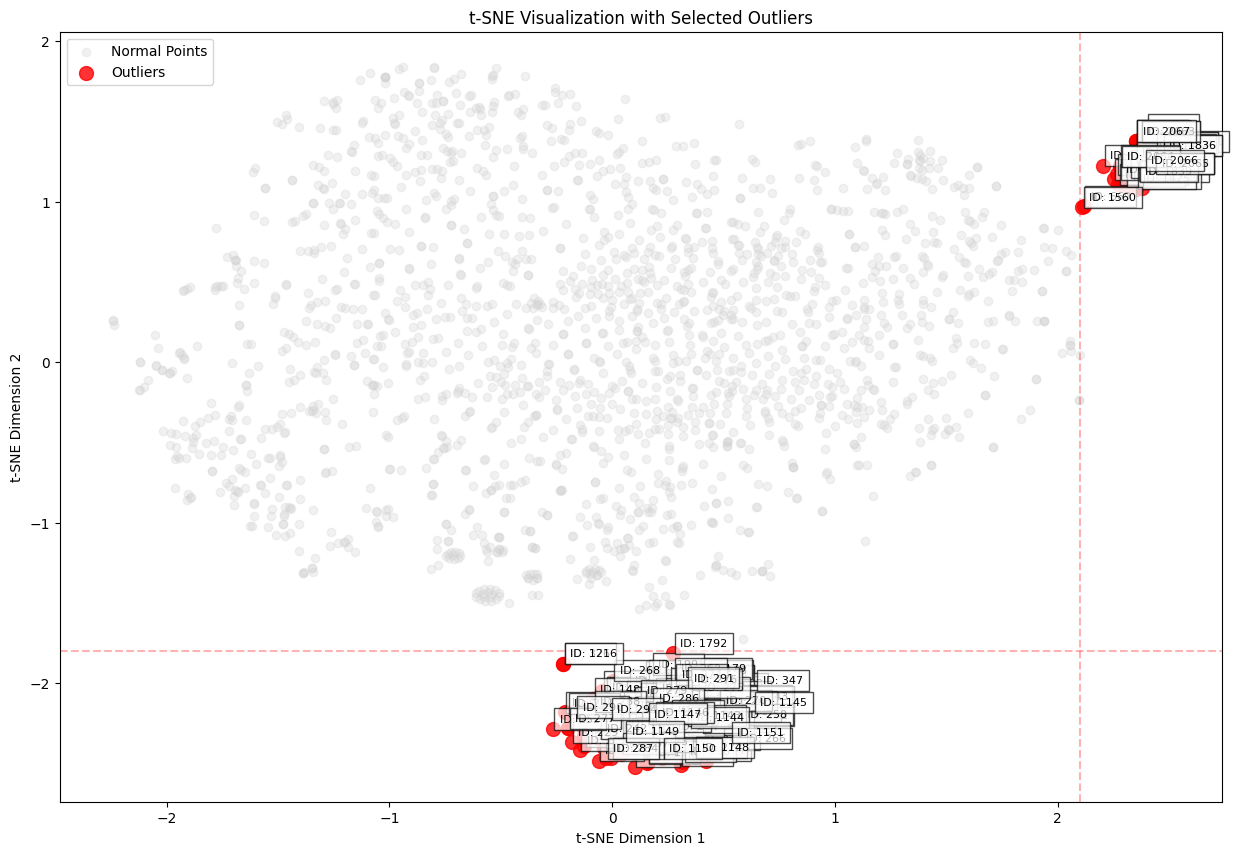

In [31]:
# Define outliers based on the specified conditions
outliers_df = df_tsne_exploring[
    (df_tsne_exploring['TSNE_2'] < -1.8) |  # Lower outliers
    (df_tsne_exploring['TSNE_1'] > 2.1)     # Right outliers
].copy()

# Separate inliers and outliers
inliers_df = df_tsne_exploring[~df_tsne_exploring.index.isin(outliers_df.index)]

# Create visualization
plt.figure(figsize=(15, 10))

# Plot all points in gray
plt.scatter(
    df_tsne_exploring[~df_tsne_exploring.index.isin(outliers_df.index)]['TSNE_1'],
    df_tsne_exploring[~df_tsne_exploring.index.isin(outliers_df.index)]['TSNE_2'],
    c='lightgray',
    alpha=0.3,
    label='Normal Points'
)

# Plot outliers in red
plt.scatter(
    outliers_df['TSNE_1'],
    outliers_df['TSNE_2'],
    c='red',
    alpha=0.8,
    s=100,
    label='Outliers'
)

# Add reference lines for outlier thresholds
plt.axhline(y=-1.8, color='r', linestyle='--', alpha=0.3)
plt.axvline(x=2.1, color='r', linestyle='--', alpha=0.3)

# Add annotations for each outlier
for idx, row in outliers_df.iterrows():
    plt.annotate(
        f"ID: {idx}",
        (row['TSNE_1'], row['TSNE_2']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8,
        bbox=dict(facecolor='white', alpha=0.7)
    )

plt.title('t-SNE Visualization with Selected Outliers')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()

### Word Frequency

In [34]:
# Analyze word frequencies in outlier and inliers emails
from collections import Counter
import re

# Get word frequencies for both groups
outlier_words = ' '.join(outliers_df['clean_content'].astype(str)).split()
inlier_words = ' '.join(inliers_df['clean_content'].astype(str)).split()

# Count word frequencies
outlier_freq = Counter(outlier_words) 
inlier_freq = Counter(inlier_words)

# Get the 20 most common words in outliers
print("\nMost common words in outlier emails:")
print("\nWord Frequency Analysis:")
for word, count in outlier_freq.most_common(20):
    print(f"{word}: {count}")

print(f"\nTotal number of outliers: {len(outliers_df)}")


Most common words in outlier emails:

Word Frequency Analysis:
enron: 1062
employees: 605
company: 604
california: 492
energy: 465
made: 455
consumers: 452
millions: 305
stock: 303
retirement: 303
donate: 302
declared: 302
bankruptcy: 302
funds: 302
million: 302
pay: 301
bills: 301
error: 230
database: 207
new: 161

Total number of outliers: 202


In [35]:
# Get the 20 most common words in inliers
print("\nMost common words in irtlier emails:")
print("\nWord Frequency Analysis:")
for word, count in inlier_freq.most_common(20):
    print(f"{word}: {count}")

print(f"\nTotal number of outliers: {len(inliers_df)}")


Most common words in irtlier emails:

Word Frequency Analysis:
enron: 11153
com: 6771
ect: 5042
hou: 2315
subject: 2078
http: 1924
e: 1923
company: 1870
new: 1517
please: 1480
pm: 1468
would: 1417
corp: 1398
www: 1343
cc: 1331
said: 1308
energy: 1235
message: 1189
may: 1160
bakernet: 1156

Total number of outliers: 1888


In [22]:
# Calculate relative frequencies (normalize by document count)
outlier_rel_freq = {word: count/len(outliers_df) for word, count in outlier_freq.items()}
inlier_rel_freq = {word: count/len(inliers_df) for word, count in inlier_freq.items()}

# Find distinctive words (words that appear more in outliers)
distinctive_words = {}
for word in outlier_freq:
    outlier_frequency = outlier_rel_freq[word]
    inlier_frequency = inlier_rel_freq.get(word, 0)  # 0 if word doesn't appear in inliers
    
    # Calculate how many times more frequent the word is in outliers
    if inlier_frequency > 0:
        ratio = outlier_frequency / inlier_frequency
    else:
        ratio = float('inf')  # Word only appears in outliers
        
    distinctive_words[word] = ratio

# Show top 20 most distinctive words and their frequency ratios
print("Top 20 words more common in outliers:")
for word, ratio in sorted(distinctive_words.items(), key=lambda x: x[1], reverse=True)[:20]:
    if outlier_freq[word] >= 5:  # Only show words that appear at least 5 times in outliers
        print(f"Word: '{word}' - {ratio:.2f}x more frequent in outliers (appears {outlier_freq[word]} times)")

Top 20 words more common in outliers:
Word: 'underhanded' - infx more frequent in outliers (appears 151 times)


In [29]:
outlier_rel_freq

# Get the 20 most common words
print("\nMost common words in outlier emails:")
print("\nWord Frequency Analysis:")
for word, count in word_freq.most_common(20):
    print(f"{word}: {count}")


Most common words in outlier emails:

Word Frequency Analysis:
enron: 1062
employees: 605
company: 604
california: 492
energy: 465
made: 455
consumers: 452
millions: 305
stock: 303
retirement: 303
donate: 302
declared: 302
bankruptcy: 302
funds: 302
million: 302
pay: 301
bills: 301
error: 230
database: 207
new: 161


## Search for e-mails:



In [36]:
# Find all cleaned emails that contain 'sell enron stock'
mask = df_tsne_exploring['clean_content'].str.contains('sell enron stock', na=False)

# Select the data from df using the mask
df_tsne_exploring.loc[mask]

,Message-ID,From,To,Date,content,clean_content,Embeddings,TSNE_1,TSNE_2
154,<6336501.1075841...,('sarah.palmer@e...,('sarah.palmer@e...,2002-02-01 14:53:35,\nJoint Venture:...,joint venture en...,{'embedding': [0...,-0.02137,-1.04293


In [38]:
# Create a list of terms to search for
searchfor = ['enron stock', 'sell stock', 'stock bonus', 'sell enron stock']
#searchfor = ['enron', 'employees', 'company', 'california']
'''
enron stock: ações da Enron
sell stock: vender ações
stock bonus: bônus em ações
sell enron stock: vender ações da Enron
'''

pd.set_option('display.max_colwidth', 20)  # Show full content of each column

# Filter cleaned emails on searchfor list and select from df 
filtered_emails = df_tsne_exploring.loc[df_tsne_exploring['clean_content'].str.contains('|'.join(searchfor), na=False)]
filtered_emails

,Message-ID,From,To,Date,content,clean_content,Embeddings,TSNE_1,TSNE_2
0,<8345058.1075840...,('advdfeedback@i...,('advdfeedback@i...,2002-01-29 23:20:55,INVESTools Advis...,investools advis...,{'embedding': [0...,-1.472167,-0.947866
1,<1512159.1075863...,('richard.sander...,('richard.sander...,2000-09-20 19:07:00,----- Forwarded ...,forwarded richar...,{'embedding': [0...,-0.041172,0.183099
2,<26118676.107586...,('m..love@enron....,('m..love@enron....,2001-10-30 16:15:17,hey you are not ...,hey wearing targ...,{'embedding': [-...,-1.160940,-0.019546
3,<10369289.107586...,('leslie.milosev...,('leslie.milosev...,2002-01-30 17:54:18,Leslie Milosevic...,leslie milosevic...,{'embedding': [0...,0.511041,-2.079606
4,<26728895.107586...,('rtwait@graphic...,('rtwait@graphic...,2002-01-30 19:36:01,Rini Twait\n1010...,rini twait e th ...,{'embedding': [0...,0.132517,-2.052758
...,...,...,...,...,...,...,...,...,...
1151,<15875618.107586...,('bandersn@loyno...,('bandersn@loyno...,2002-01-30 17:54:12,Blanca Anderson\...,blanca anderson ...,{'embedding': [0...,0.529807,-2.368706
1450,<30798399.107584...,('chairman.enron...,('chairman.enron...,2002-01-16 14:45:55,\nEnron announce...,enron announced ...,{'embedding': [0...,-0.337884,-1.341780
1473,<957052.10758613...,('chairman.ken@e...,('chairman.ken@e...,2001-11-09 23:48:54,"\nToday, we anno...",today announced ...,{'embedding': [-...,-0.118445,-1.298769
1557,<18936682.107586...,('resources.huma...,('resources.huma...,2001-11-25 23:15:46,We've updated th...,updated merger q...,{'embedding': [-...,-0.569857,-1.486661


### Flagging E-mails

In [39]:
df_tsne_exploring["Flag"] = np.where(df_tsne_exploring["clean_content"].str.contains('|'.join(searchfor), na=False), 1, 0)
df_tsne_exploring

,Message-ID,From,To,Date,content,clean_content,Embeddings,TSNE_1,TSNE_2,Flag
0,<8345058.1075840...,('advdfeedback@i...,('advdfeedback@i...,2002-01-29 23:20:55,INVESTools Advis...,investools advis...,{'embedding': [0...,-1.472167,-0.947866,1
1,<1512159.1075863...,('richard.sander...,('richard.sander...,2000-09-20 19:07:00,----- Forwarded ...,forwarded richar...,{'embedding': [0...,-0.041172,0.183099,1
2,<26118676.107586...,('m..love@enron....,('m..love@enron....,2001-10-30 16:15:17,hey you are not ...,hey wearing targ...,{'embedding': [-...,-1.160940,-0.019546,1
3,<10369289.107586...,('leslie.milosev...,('leslie.milosev...,2002-01-30 17:54:18,Leslie Milosevic...,leslie milosevic...,{'embedding': [0...,0.511041,-2.079606,1
4,<26728895.107586...,('rtwait@graphic...,('rtwait@graphic...,2002-01-30 19:36:01,Rini Twait\n1010...,rini twait e th ...,{'embedding': [0...,0.132517,-2.052758,1
...,...,...,...,...,...,...,...,...,...,...
2085,<19039088.107585...,('andy.zipper@en...,('andy.zipper@en...,2001-10-22 14:00:17,"i bot 1,000/d at...",bot apr oct put ...,{'embedding': [0...,1.894027,0.572757,0
2086,<6813352.1075842...,('andy.zipper@en...,('andy.zipper@en...,2002-01-25 17:39:38,I'm okay. How ar...,okay,{'embedding': [0...,-0.791879,1.613964,0
2087,<4833106.1075842...,('tradersummary@...,('tradersummary@...,2002-02-01 16:15:17,\n[IMAGE]=09\n\n...,image image imag...,{'embedding': [0...,-0.189357,-1.226607,0
2088,<3550151.1075842...,('lmrig@qwest.net'),('lmrig@qwest.net'),2002-01-29 02:01:00,\n\nTransmission...,transmission exp...,{'embedding': [0...,0.465391,-0.878047,0


In [40]:
df_tsne_exploring["Flag"].value_counts()

Flag
0    1776
1     314
Name: count, dtype: int64

### Exploring the t-SNE with Flagged e-mails

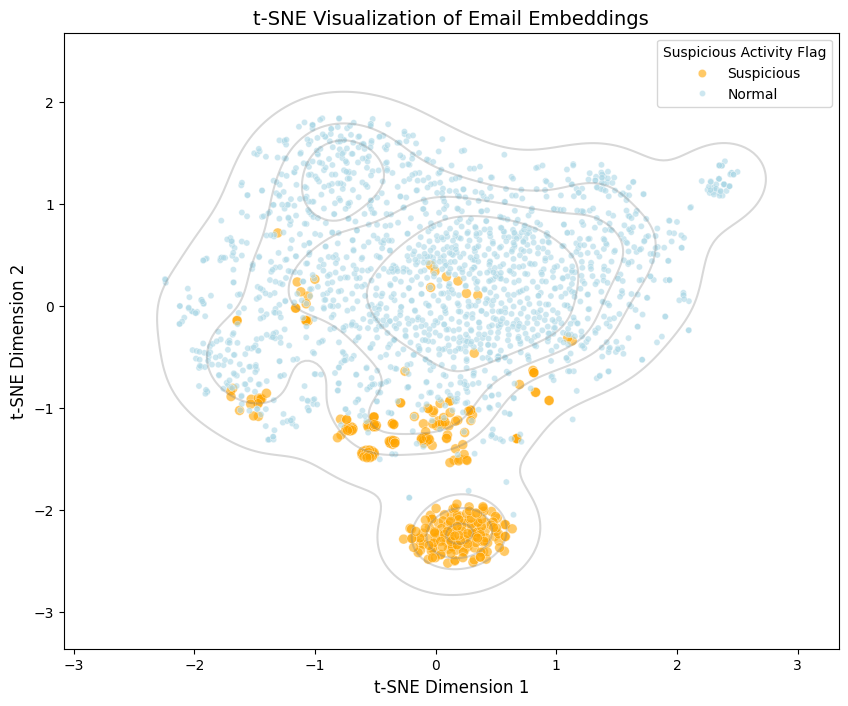


Distribution of points:


TSNE_1                                                              \
       count      mean       std       min       25%       50%       75%   
Flag                                                                       
0     1776.0  0.014677  1.059374 -2.242381 -0.801357  0.026646  0.760476   
1      314.0 -0.083012  0.552135 -1.697894 -0.357773  0.051192  0.270538   

                TSNE_2                                                    \
           max   count      mean       std       min       25%       50%   
Flag                                                                       
0     2.501315  1776.0  0.281953  0.745953 -2.045976 -0.280144  0.292213   
1     1.131312   314.0 -1.594740  0.720663 -2.520200 -2.235663 -1.494050   

                          
           75%       max  
Flag                      
0     0.855418  1.841419  
1    -1.153348  0.717518

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a larger figure
plt.figure(figsize=(10, 8))

# Create scatter plot with more visual information
scatter = sns.scatterplot(
    data=df_tsne_exploring,
    x="TSNE_1",
    y="TSNE_2",
    hue="Flag",
    alpha=0.6,  # Add some transparency
    palette=["lightblue", "orange"],  # Blue for 0, Red for 1
    size="Flag",  # Make flagged points larger
    sizes=(50, 20)  # Size range for points
)

# Add title and labels
plt.title("t-SNE Visualization of Email Embeddings", fontsize=14)
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)

# Add legend with clear labels
plt.legend(title="Suspicious Activity Flag", labels=["Suspicious", "Normal"])

# Add density contours to show clustering
sns.kdeplot(
    data=df_tsne,
    x="TSNE_1",
    y="TSNE_2",
    levels=5,
    color="gray",
    alpha=0.3
)

plt.show()

# Print some statistics
print("\nDistribution of points:")
df_tsne_exploring.groupby("Flag")[["TSNE_1", "TSNE_2"]].describe()

## KMeans

In [193]:
from sklearn.cluster import KMeans

# Perform K-means clustering
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_tsne['Cluster_KMeans'] = kmeans.fit_predict(df_tsne[['TSNE_1', 'TSNE_2']])

# Calculate flag ratio per cluster
cluster_analysis = df_tsne.groupby('Cluster_KMeans').agg({
    'Flag': ['count', 'mean'],
    'TSNE_1': 'mean',
    'TSNE_2': 'mean'
}).round(3)

print("\nCluster KMeans Analysis:")
print("(Flag mean shows proportion of suspicious emails in each cluster)")
cluster_analysis


Cluster KMeans Analysis:
(Flag mean shows proportion of suspicious emails in each cluster)


Flag        TSNE_1 TSNE_2
               count   mean   mean   mean
Cluster_KMeans                           
0                402  0.070 -1.255 -0.268
1                549  0.011 -0.467  0.912
2                485  0.569  0.061 -1.338
3                654  0.006  1.119  0.391

In [194]:
df_tsne.head()

,Message-ID,From,To,Date,content,clean_content,Flag,Embeddings,TSNE_1,TSNE_2,Cluster_KMeans
0,<8345058.1075840404046.JavaMail.evans@thyme>,('advdfeedback@investools.com'),('advdfeedback@investools.com'),2002-01-29 23:20:55,INVESTools Advisory\nA Free Digest of Trusted ...,investools advisory free digest trusted invest...,1,"{'embedding': [0.0060157324, -0.0055038417, -0...",-1.472167,-0.947866,0
1,<1512159.1075863666797.JavaMail.evans@thyme>,('richard.sanders@enron.com'),('richard.sanders@enron.com'),2000-09-20 19:07:00,----- Forwarded by Richard B Sanders/HOU/ECT o...,forwarded richard b sanders hou ect pm justin ...,1,"{'embedding': [0.0122758085, -0.038377106, -0....",-0.041172,0.183099,1
2,<26118676.1075862176383.JavaMail.evans@thyme>,('m..love@enron.com'),('m..love@enron.com'),2001-10-30 16:15:17,hey you are not wearing your target purple shi...,hey wearing target purple shirt today mine wan...,1,"{'embedding': [-0.010328788, -0.006901007, -0....",-1.160940,-0.019546,0
3,<10369289.1075860831062.JavaMail.evans@thyme>,('leslie.milosevich@kp.org'),('leslie.milosevich@kp.org'),2002-01-30 17:54:18,Leslie Milosevich\n1042 Santa Clara Avenue\nAl...,leslie milosevich santa clara avenue alameda c...,1,"{'embedding': [0.010876484, 0.02684665, -0.031...",0.511041,-2.079606,2
4,<26728895.1075860815046.JavaMail.evans@thyme>,('rtwait@graphicaljazz.com'),('rtwait@graphicaljazz.com'),2002-01-30 19:36:01,"Rini Twait\n1010 E 5th Ave\nLongmont, CO 80501...",rini twait e th ave longmont co rtwait graphic...,1,"{'embedding': [0.011247741, 0.01880242, -0.041...",0.132517,-2.052758,2


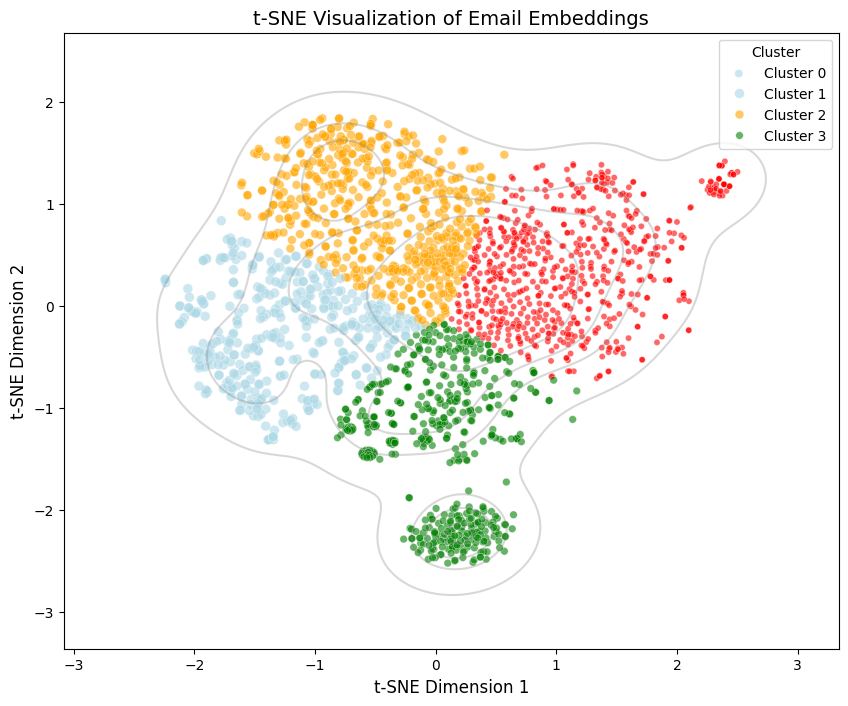


Distribution of points:


TSNE_1                                                    \
                count      mean       std       min       25%       50%   
Cluster_KMeans                                                            
0               402.0 -1.255217  0.494950 -2.242381 -1.661733 -1.326909   
1               549.0 -0.467137  0.500295 -1.610864 -0.855943 -0.435024   
2               485.0  0.060715  0.378747 -0.813508 -0.156807  0.105266   
3               654.0  1.118668  0.569488  0.132798  0.653522  1.072784   

                                   TSNE_2                                \
                     75%       max  count      mean       std       min   
Cluster_KMeans                                                            
0              -0.872986 -0.118942  402.0 -0.267835  0.461894 -1.310604   
1              -0.041172  0.569018  549.0  0.912128  0.504231 -0.184687   
2               0.313619  1.169254  485.0 -1.338114  0.687278 -2.520200   
3               1.463288  2.501315  654.0  0.391279  0.528462 -0.707611   

                                                        
                     25%       50%       75%       max  
Cluster_KMeans                                          
0              -0.600000 -0.227434  0.056801  0.837720  
1               0.490508  0.928868  1.317807  1.841419  
2              -2.108378 -1.189961 -0.793324 -0.177767  
3              -0.050582  0.379499  0.768775  1.419994

In [196]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a larger figure
plt.figure(figsize=(10, 8))

# Create scatter plot with more visual information
scatter = sns.scatterplot(
    data=df_tsne,
    x="TSNE_1",
    y="TSNE_2",
    hue="Cluster_KMeans",
    alpha=0.6,  # Add some transparency
    palette=["lightblue", "orange", "green", "red"],  # Blue for 0, Red for 1
    size="Cluster_KMeans",  # Make flagged points larger
    sizes=(50, 20)  # Size range for points
)

# Add title and labels
plt.title("t-SNE Visualization of Email Embeddings", fontsize=14)
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)

# Add legend with clear labels
plt.legend(title="Cluster", labels=["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"])

# Add density contours to show clustering
sns.kdeplot(
    data=df_tsne,
    x="TSNE_1",
    y="TSNE_2",
    levels=5,
    color="gray",
    alpha=0.3
)

plt.show()

# Print some statistics
print("\nDistribution of points:")
df_tsne.groupby("Cluster_KMeans")[["TSNE_1", "TSNE_2"]].describe()

## DBSCAN


Best parameters: eps                0.100000
min_samples       25.000000
n_clusters         1.000000
noise_points    2058.000000
silhouette         0.319213
calinski         117.685936
noise_ratio        0.984689
Name: 4, dtype: float64


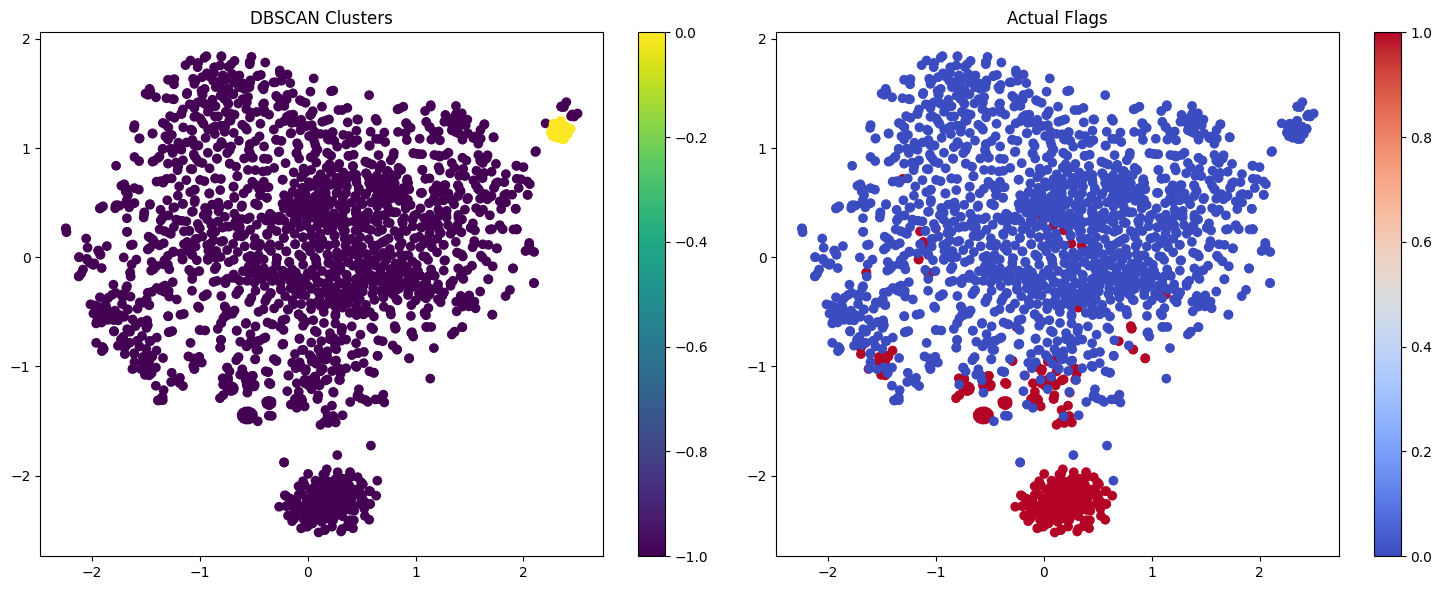

In [203]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import numpy as np
import matplotlib.pyplot as plt

# Test parameters grid - adjusted ranges based on t-SNE scale
eps_range = np.arange(0.1, 2.0, 0.2)      # Smaller steps, wider range
min_samples_range = np.arange(5, 30, 5)    # Focus on key sample sizes

results = []

# Test combinations
for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(df_tsne[['TSNE_1', 'TSNE_2']])
        
        if len(set(labels)) > 1:  # Skip if all noise
            # Calculate cluster quality metrics
            sil_score = silhouette_score(df_tsne[['TSNE_1', 'TSNE_2']], labels)
            ch_score = calinski_harabasz_score(df_tsne[['TSNE_1', 'TSNE_2']], labels)
            
            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': len(set(labels)) - 1,
                'noise_points': list(labels).count(-1),
                'silhouette': sil_score,
                'calinski': ch_score,
                'noise_ratio': list(labels).count(-1) / len(labels)
            })

# Find best parameters
results_df = pd.DataFrame(results)
best_params = results_df.loc[results_df['silhouette'].idxmax()]
print("\nBest parameters:", best_params)

# Plot best clustering
best_dbscan = DBSCAN(eps=best_params['eps'], min_samples=int(best_params['min_samples']))
df_tsne['Cluster_DBSCAN'] = best_dbscan.fit_predict(df_tsne[['TSNE_1', 'TSNE_2']])

# Plot with both cluster colors and fraud flags
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Cluster plot
scatter1 = ax1.scatter(df_tsne['TSNE_1'], df_tsne['TSNE_2'], 
                      c=df_tsne['Cluster_DBSCAN'], cmap='viridis')
ax1.set_title('DBSCAN Clusters')
plt.colorbar(scatter1, ax=ax1)

# Flag plot
scatter2 = ax2.scatter(df_tsne['TSNE_1'], df_tsne['TSNE_2'], 
                      c=df_tsne['Flag'], cmap='coolwarm')
ax2.set_title('Actual Flags')
plt.colorbar(scatter2, ax=ax2)

plt.tight_layout()
plt.show()

In [186]:
df_tsne.head()

,Message-ID,From,To,Date,content,clean_content,Flag,Embeddings,TSNE_1,TSNE_2,Cluster_KMeans,cluster
0,<8345058.1075840404046.JavaMail.evans@thyme>,('advdfeedback@investools.com'),('advdfeedback@investools.com'),2002-01-29 23:20:55,INVESTools Advisory\nA Free Digest of Trusted ...,investools advisory free digest trusted invest...,1,"{'embedding': [0.0060157324, -0.0055038417, -0...",-1.472167,-0.947866,0,-1
1,<1512159.1075863666797.JavaMail.evans@thyme>,('richard.sanders@enron.com'),('richard.sanders@enron.com'),2000-09-20 19:07:00,----- Forwarded by Richard B Sanders/HOU/ECT o...,forwarded richard b sanders hou ect pm justin ...,1,"{'embedding': [0.0122758085, -0.038377106, -0....",-0.041172,0.183099,3,-1
2,<26118676.1075862176383.JavaMail.evans@thyme>,('m..love@enron.com'),('m..love@enron.com'),2001-10-30 16:15:17,hey you are not wearing your target purple shi...,hey wearing target purple shirt today mine wan...,1,"{'embedding': [-0.010328788, -0.006901007, -0....",-1.160940,-0.019546,0,-1
3,<10369289.1075860831062.JavaMail.evans@thyme>,('leslie.milosevich@kp.org'),('leslie.milosevich@kp.org'),2002-01-30 17:54:18,Leslie Milosevich\n1042 Santa Clara Avenue\nAl...,leslie milosevich santa clara avenue alameda c...,1,"{'embedding': [0.010876484, 0.02684665, -0.031...",0.511041,-2.079606,2,-1
4,<26728895.1075860815046.JavaMail.evans@thyme>,('rtwait@graphicaljazz.com'),('rtwait@graphicaljazz.com'),2002-01-30 19:36:01,"Rini Twait\n1010 E 5th Ave\nLongmont, CO 80501...",rini twait e th ave longmont co rtwait graphic...,1,"{'embedding': [0.011247741, 0.01880242, -0.041...",0.132517,-2.052758,2,-1


## Other Clustering Methods

c:\Users\danrl\miniconda3\envs\llm_env\lib\site-packages\sklearn\cluster\_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


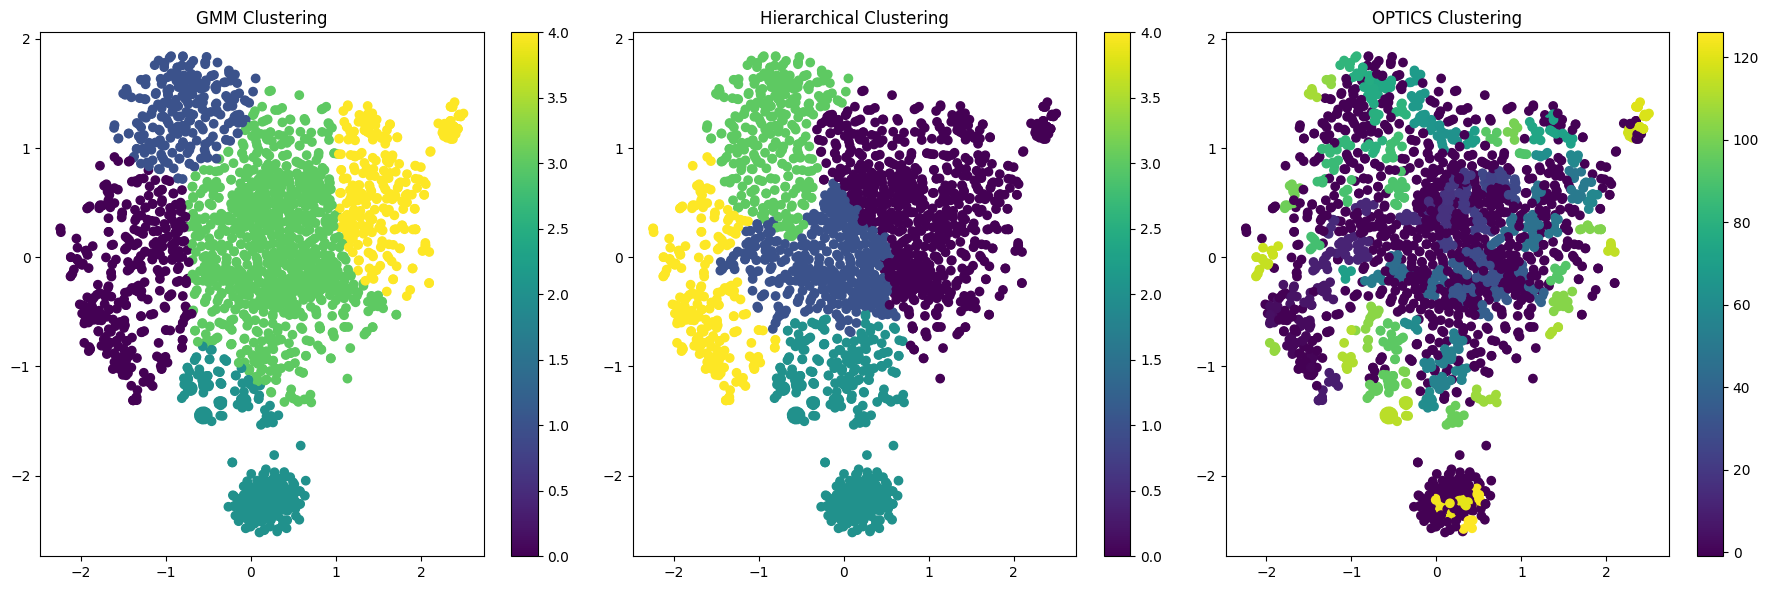


Silhouette Scores:
GMM: 0.352
Hierarchical: 0.340
OPTICS: -0.166

Best method: GMM


In [204]:
from sklearn.cluster import KMeans, AgglomerativeClustering, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# 1. Gaussian Mixture Model (GMM)
def try_gmm(n_components=5):
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    clusters = gmm.fit_predict(df_tsne[['TSNE_1', 'TSNE_2']])
    return clusters, 'GMM'

# 2. Hierarchical Clustering
def try_hierarchical(n_clusters=5):
    hc = AgglomerativeClustering(n_clusters=n_clusters)
    clusters = hc.fit_predict(df_tsne[['TSNE_1', 'TSNE_2']])
    return clusters, 'Hierarchical'

# 3. OPTICS (improved DBSCAN)
def try_optics(min_samples=5):
    optics = OPTICS(min_samples=min_samples)
    clusters = optics.fit_predict(df_tsne[['TSNE_1', 'TSNE_2']])
    return clusters, 'OPTICS'

# Try all methods and compare
methods = [
    (try_gmm, {}),
    (try_hierarchical, {}),
    (try_optics, {})
]

# Plot results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
scores = []

for (method_func, params), ax in zip(methods, axes):
    clusters, name = method_func(**params)
    
    # Plot clusters
    scatter = ax.scatter(df_tsne['TSNE_1'], df_tsne['TSNE_2'], 
                        c=clusters, cmap='viridis')
    ax.set_title(f'{name} Clustering')
    plt.colorbar(scatter, ax=ax)
    
    # Calculate silhouette score
    if len(set(clusters)) > 1:  # Only if more than one cluster
        score = silhouette_score(df_tsne[['TSNE_1', 'TSNE_2']], clusters)
        scores.append((name, score))

plt.tight_layout()
plt.show()

# Print scores
print("\nSilhouette Scores:")
for name, score in scores:
    print(f"{name}: {score:.3f}")

# Use best method for detailed analysis
best_method = max(scores, key=lambda x: x[1])[0]
print(f"\nBest method: {best_method}")

## Gaussian Mixture Model

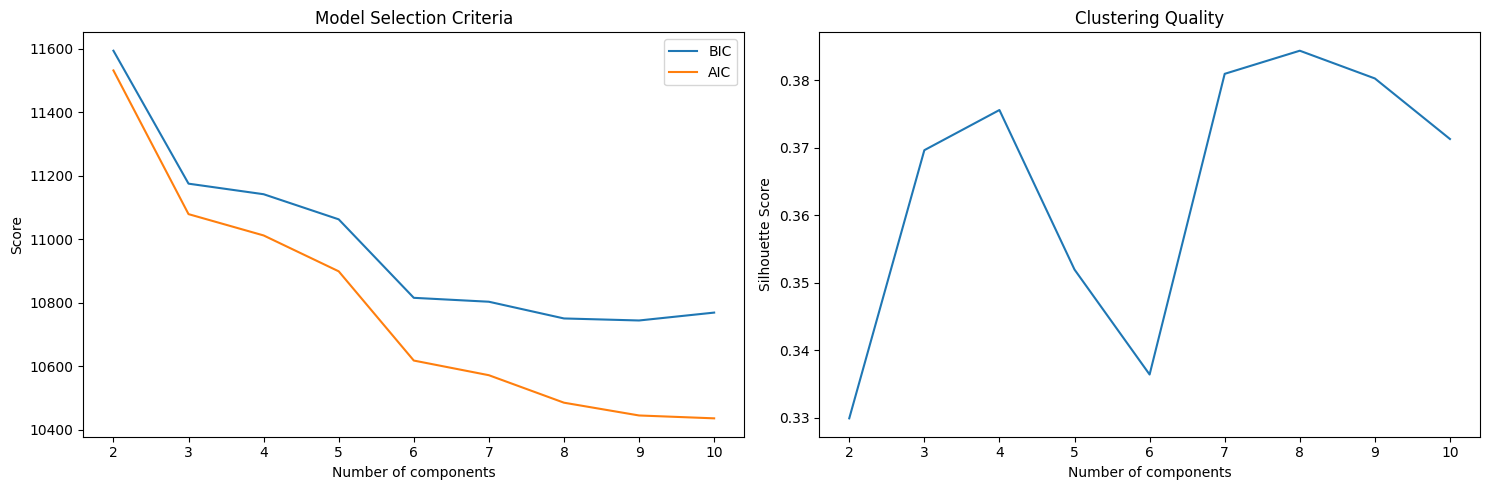


Best number of components: 3


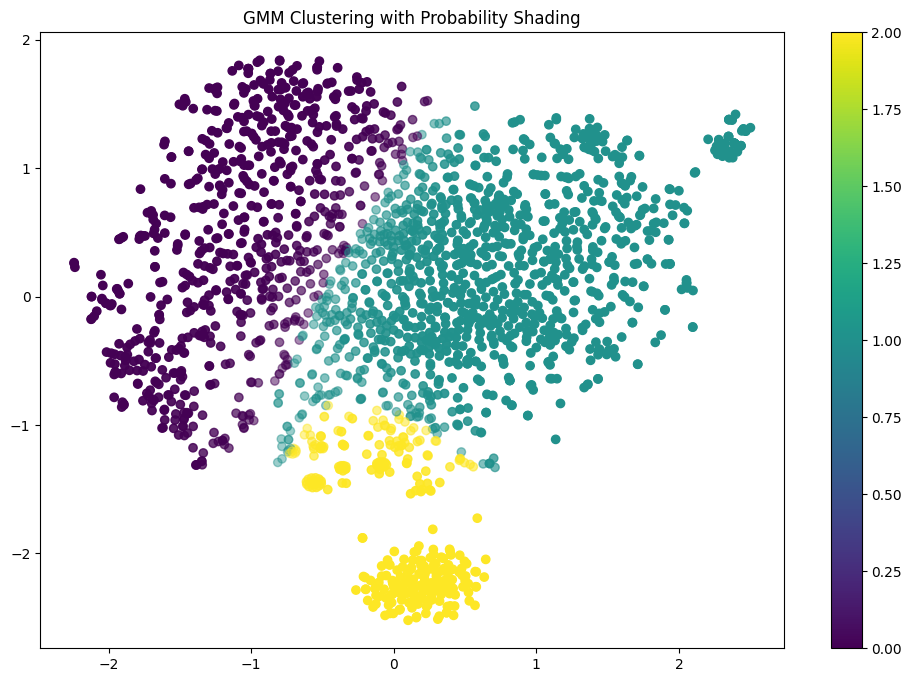


Cluster Analysis:
             Flag        GMM_Prob
            count   mean     mean
GMM_Cluster                      
0             708  0.041    0.903
1            1088  0.034    0.902
2             294  0.844    0.870


<bound method _AxesBase.set_ylabel of <Axes: title={'center': 'Cluster Sizes'}, xlabel='Cluster'>>

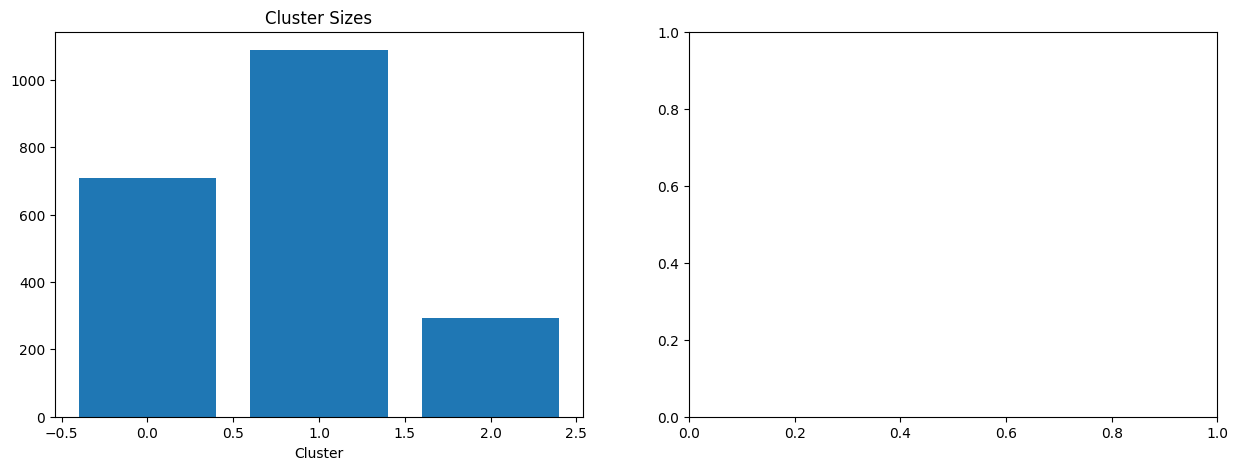

In [207]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Find optimal number of components
def optimize_gmm(max_components=10):
    n_components_range = range(2, max_components + 1)
    bic = []
    aic = []
    silhouette_scores = []
    
    for n in n_components_range:
        gmm = GaussianMixture(n_components=n, random_state=42)
        labels = gmm.fit_predict(df_tsne[['TSNE_1', 'TSNE_2']])
        
        bic.append(gmm.bic(df_tsne[['TSNE_1', 'TSNE_2']]))
        aic.append(gmm.aic(df_tsne[['TSNE_1', 'TSNE_2']]))
        silhouette_scores.append(silhouette_score(df_tsne[['TSNE_1', 'TSNE_2']], labels))
    
    return n_components_range, bic, aic, silhouette_scores

# Plot optimization metrics
n_range, bic, aic, sil_scores = optimize_gmm()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(n_range, bic, label='BIC')
ax1.plot(n_range, aic, label='AIC')
ax1.set_xlabel('Number of components')
ax1.set_ylabel('Score')
ax1.legend()
ax1.set_title('Model Selection Criteria')

ax2.plot(n_range, sil_scores)
ax2.set_xlabel('Number of components')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Clustering Quality')

plt.tight_layout()
plt.show()

# 2. Fit best GMM model
best_n = n_range[np.argmax(sil_scores)]
best_n = 3
print(f"\nBest number of components: {best_n}")

gmm = GaussianMixture(n_components=best_n, random_state=42)
df_tsne['GMM_Cluster'] = gmm.fit_predict(df_tsne[['TSNE_1', 'TSNE_2']])
df_tsne['GMM_Prob'] = gmm.predict_proba(df_tsne[['TSNE_1', 'TSNE_2']]).max(axis=1)

# 3. Visualize results
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_tsne['TSNE_1'], df_tsne['TSNE_2'], 
                     c=df_tsne['GMM_Cluster'], 
                     alpha=df_tsne['GMM_Prob'],
                     cmap='viridis')
plt.colorbar(scatter)
plt.title('GMM Clustering with Probability Shading')
plt.show()

# 4. Analyze clusters
print("\nCluster Analysis:")
cluster_stats = df_tsne.groupby('GMM_Cluster').agg({
    'Flag': ['count', 'mean'],
    'GMM_Prob': 'mean'
}).round(3)
print(cluster_stats)

# 5. Plot cluster characteristics
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Cluster sizes
cluster_sizes = df_tsne['GMM_Cluster'].value_counts()
axes[0].bar(cluster_sizes.index, cluster_sizes.values)
axes[0].set_title('Cluster Sizes')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel